In [1]:
#Library for Mathemtical Computation
import numpy as np
import pandas as pd 

#Library for Modelling 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error


#Library for Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# download dataset at https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data
train_data = pd.read_csv('sales_train.csv')
test_data = pd.read_csv('test.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
items_categories = pd.read_csv('item_categories.csv')

In [17]:
train_data.shape

(2935849, 6)

In [18]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [19]:
test_data.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


PREPARING TRAINING DATA

In [20]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [21]:
#Displaying Stats on Training Data
train_data.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [22]:
#Changing Negative numbers into Positive
train_data['item_price']=train_data['item_price'].abs()
train_data['item_cnt_day']=train_data['item_cnt_day'].abs()

In [23]:
#Checking if the training data has any Null values or not
null_percent=100*(train_data.isnull().sum()/len(train_data))
print(null_percent)

date              0.0
date_block_num    0.0
shop_id           0.0
item_id           0.0
item_price        0.0
item_cnt_day      0.0
dtype: float64


In [24]:
days = []
months = []
years = []

train_data['date'] = pd.to_datetime(train_data['date'], errors='coerce')

for day in train_data['date']:
    days.append(day.day)
for month in train_data['date']:
    months.append(month.month)
for year in train_data['date']:
    years.append(year.year)

train_data['day'] = days
train_data['month'] = months
train_data['year'] = years
train_data['revenue'] = train_data.item_price * train_data.item_cnt_day

train_data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,revenue
0,2013-02-01,0,59,22154,999.00,1.0,1,2,2013,999.00
1,2013-03-01,0,25,2552,899.00,1.0,1,3,2013,899.00
2,2013-05-01,0,25,2552,899.00,1.0,1,5,2013,899.00
3,2013-06-01,0,25,2554,1709.05,1.0,1,6,2013,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,15,1,2013,1099.00
...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,10,10,2015,299.00
2935845,2015-09-10,33,25,7460,299.00,1.0,10,9,2015,299.00
2935846,2015-10-14,33,25,7459,349.00,1.0,14,10,2015,349.00
2935847,2015-10-22,33,25,7440,299.00,1.0,22,10,2015,299.00


In [25]:
#Grouping item price and item count per month
train_data=train_data.groupby(['date_block_num','shop_id','item_id', 'day', 'month', 'year', 'revenue']).agg({'item_price':'last','item_cnt_day':'sum'}).reset_index()
#Changing the name of the item_cnt_day to item_cnt_month
train_data=train_data.rename(columns={'item_cnt_day':'item_cnt_month'})
train_data

,date_block_num,shop_id,item_id,day,month,year,revenue,item_price,item_cnt_month
0,0,0,32,1,3,2013,442.0,221.0,2.0
1,0,0,32,21,1,2013,442.0,221.0,2.0
2,0,0,32,25,1,2013,221.0,221.0,1.0
3,0,0,32,31,1,2013,221.0,221.0,1.0
4,0,0,33,1,3,2013,347.0,347.0,1.0
...,...,...,...,...,...,...,...,...,...
2935838,33,59,22088,10,3,2015,119.0,119.0,1.0
2935839,33,59,22088,27,10,2015,119.0,119.0,1.0
2935840,33,59,22091,10,3,2015,179.0,179.0,1.0
2935841,33,59,22100,18,10,2015,629.0,629.0,1.0


In [26]:
items.head(1)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40


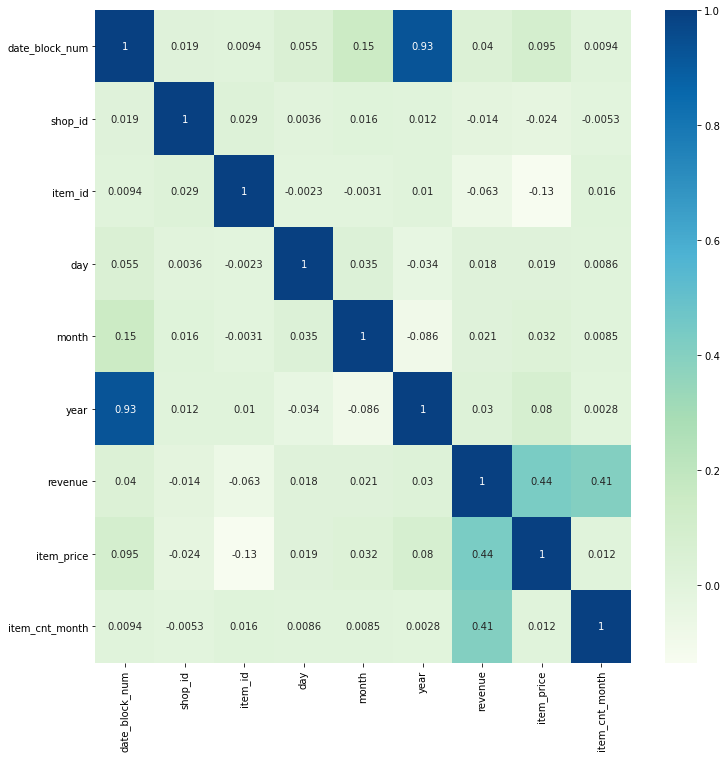

In [27]:
#Calculating Correlation
correlation=train_data.corr()

#Plotting correlation
plt.figure(figsize=(12,12))
corr_heatmap=sns.heatmap(correlation,annot=True,cmap="GnBu")

In [28]:
# merge item vs item_category_id
train_data = pd.merge(train_data, items, on=['item_id'], how='left')
train_data = train_data.drop(columns=['item_name'], axis=1)
train_data.head(1)

,date_block_num,shop_id,item_id,day,month,year,revenue,item_price,item_cnt_month,item_category_id
0,0,0,32,1,3,2013,442.0,221.0,2.0,40


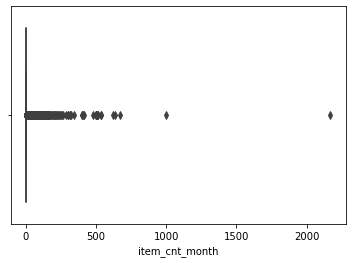

In [29]:
sns.boxplot(x=train_data.item_cnt_month)

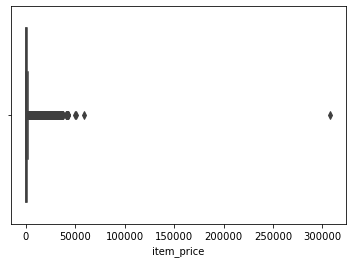

In [30]:
sns.boxplot(x=train_data.item_price)

In [31]:
train_data = train_data[(train_data.item_price < 30000) & (train_data.item_cnt_month < 1000)]

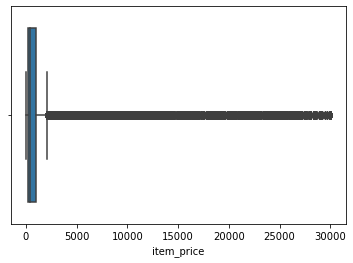

In [32]:
sns.boxplot(x=train_data.item_price)

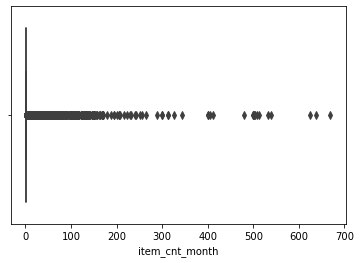

In [34]:
sns.boxplot(x=train_data.item_cnt_month)

In [18]:
train_data_copy = train_data.copy()
train_data_copy = train_data_copy[['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'item_price', 'item_cnt_month']]
train_data_copy.head(1)

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_month
0,0,0,32,40,221.0,2.0


In [19]:
train_data_copy

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_month
0,0,0,32,40,221.0,2.0
1,0,0,32,40,221.0,2.0
2,0,0,32,40,221.0,1.0
3,0,0,32,40,221.0,1.0
4,0,0,33,37,347.0,1.0
...,...,...,...,...,...,...
2935838,33,59,22088,83,119.0,1.0
2935839,33,59,22088,83,119.0,1.0
2935840,33,59,22091,83,179.0,1.0
2935841,33,59,22100,42,629.0,1.0


In [20]:
from sklearn.model_selection import train_test_split

X = train_data_copy.drop('item_cnt_month', axis=1)
y = train_data_copy['item_cnt_month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2054920, 5), (880681, 5), (2054920,), (880681,))

In [21]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)

LinearRegression()

In [22]:
train_y_pred = lrm.predict(X_train)
test_y_pred = lrm.predict(X_test)

In [23]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_y_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_y_pred))
print("LR train RMSE: ", train_rmse)
print("LR test RMSe: ", test_rmse)

LR train RMSE:  2.183658420241962
LR test RMSe:  2.282427772701547


DECISION TREE

In [24]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_depth=50)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=50)

In [25]:
train_y_pred = dtr.predict(X_train)
test_y_pred = dtr.predict(X_test)

In [26]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_y_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_y_pred))
print("DTR train RMSE: ", train_rmse)
print("DTR test RMSE: ", test_rmse)

DTR train RMSE:  1.200893781006535
DTR test RMSE:  2.133842980242523


RANDOM FOREST REGRESSION

In [27]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth=50, n_estimators=100)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=50)

In [28]:
test_rfr_pred = rfr.predict(X_test)
train_rfr_pred = rfr.predict(X_train)

In [29]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_rfr_pred))
train_rmse = np.sqrt(mean_squared_error(y_train, train_rfr_pred))
print("Train RMSE: ", train_rmse)
print("Test RMSE: ", test_rmse)

Train RMSE:  1.2903619554774706
Test RMSE:  1.9847751266553655


In [ ]:
n_estimators = [int(x) for x in np.linspace(start=10, stop=300, num=25)]
max_features = ['auto', 'sqrt']
max_depth = [3, 100]
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

In [ ]:
# create the param grid
param_grid = {
    'max_features': max_features,
    'n_esimators': n_estimators,
    'max_depth': max_depth,
}
print(param_grid)

In [ ]:
from sklearn.model_selection import GridSearchCV

rfr_grid = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=3, verbose=2, n_jobs=4)

In [ ]:
rfr_grid.best_estimator_

In [ ]:
rfr

In [ ]:
#################### phần dưới đây xử lý sau #####################################

In [ ]:
item_price = dict(train_data.groupby('item_id')['item_price'].last().reset_index().values)
train_data_copy['item_price'] = train_data_copy.item_id.map(item_price)

In [ ]:
train_data_copy = train_data_copy.groupby(['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_category_id']).agg({'item_cnt_month':'sum'}).reset_index()
train_data_copy

In [ ]:
train_data_copy['item_revenue'] = train_data_copy.item_price * train_data_copy.item_cnt_month
train_data_copy

In [ ]:
X_train

PREPARING TEST DATA

In [ ]:
#Adding date_block_num to the Test data
test_data['date_block_num']=34
test_data=test_data[['date_block_num','shop_id','item_id']]
test_data.head(1)

In [ ]:
# day = dict(train_data.groupby('item_id')['day'].last().reset_index().values)
# month = dict(train_data.groupby('item_id')['month'].last().reset_index().values)
# year = dict(train_data.groupby('item_id')['year'].last().reset_index().values)
item_category_id = dict(items.groupby('item_id')['item_category_id'].last().reset_index().values)
item_price = dict(train_data_copy.groupby('item_id')['item_price'].first().reset_index().values)
item_revenue = dict(train_data_copy.groupby('item_id')['item_revenue'].first().reset_index().values)

In [ ]:
test_data_copy = test_data.copy()

In [ ]:
# test_data_copy['day'] = test_data_copy.item_id.map(day)
# test_data_copy['month'] = test_data_copy.item_id.map(month)
# test_data_copy['year'] = test_data_copy.item_id.map(year)
test_data_copy['item_category_id'] = test_data_copy.item_id.map(item_category_id)
test_data_copy['item_price'] = test_data_copy.item_id.map(item_price)
test_data_copy['item_revenue'] = test_data_copy.item_id.map(item_revenue)
test_data_copy

In [ ]:
test_data_copy = test_data_copy[['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'item_price', 'item_revenue']]
test_data_copy['item_price'] = test_data_copy['item_price'].fillna(test_data_copy['item_price'].median())
test_data_copy['item_revenue'] = test_data_copy['item_revenue'].fillna(test_data_copy['item_revenue'].median())
test_data_copy.head(3)

In [ ]:
item_category_id = dict(items.groupby('item_id')['item_category_id'].last().reset_index().values)
test_data_copy['item_category_id'] = test_data_copy.item_id.map(item_category_id)

In [ ]:
prediction = test_data_copy[['date_block_num', 'shop_id', 'item_id', 'item_category_id']]
rfr.predict()

In [ ]:
predict_sale = rfr.predict(prediction)

In [ ]:
test_data_copy['item_cnt_month'] = predict_sale

In [ ]:
test_data_copy

In [ ]:
test_data_copy['revenue'] = test_data_copy.item_price * test_data_copy.item_cnt_month
test_data_copy

In [ ]:
shop_45 = test_data_copy[test_data_copy.shop_id == 45]
shop_45 = shop_45.groupby(['date_block_num']).agg({'revenue': 'sum'}).reset_index()
shop_45

PREPARING FOR MODELLING

In [ ]:
#allocating training data into X and y training sets
x_train = train_data_copy.drop('item_cnt_month',axis=1)
y_train = train_data_copy["item_cnt_month"]
x_valid = train_data_copy[train_data_copy.date_block_num == 33].drop(columns=['item_cnt_month'])
y_valid = train_data_copy[train_data_copy.date_block_num == 33]['item_cnt_month'].values
x_test = test_data_copy
x_train.shape, y_train.shape, x_test.shape

TRAINING THE MODEL

Linear Regression

In [ ]:
#Training the model
linear_model=LinearRegression()
linear_model.fit(x_train,y_train)

In [ ]:
#Testing the model
lr_pred_train = linear_model.predict(x_train)
lr_pred_test = linear_model.predict(x_test)
lr_pred_val = linear_model.predict(x_valid)

In [ ]:
#output is the predicted cnt_per_month
print(lr_pred_test)

In [ ]:
# rmse 
rmse_train = np.sqrt(mean_squared_error(y_train, lr_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_valid, lr_pred_val))
rmse_train, rmse_test

In [ ]:
from sklearn.model_selection import train_test_split

X = train_data.drop('item_cnt_month', axis=1)
y = train_data['item_cnt_month']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_depth=7)
dtr.fit(x_train, y_train)


In [ ]:
dtr_pred_train = dtr.predict(x_train)
dtr_pred_val = dtr.predict(x_valid)
dtr_pred_test = dtr.predict(x_test)

In [ ]:
# rmse 
rmse_train = np.sqrt(mean_squared_error(y_train, dtr_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_valid, dtr_pred_val))
rmse_train, rmse_test

Random Forest

In [ ]:
#Buliding Model in Random Forest Regressor
rr_model=RandomForestRegressor(max_depth=7, n_estimators=10, random_state=0)
rr_model.fit(x_train,y_train)

In [ ]:
rfr_pred_train = rr_model.predict(x_train)
rfr_pred_val = rr_model.predict(x_valid)
rfr_pred_test = rr_model.predict(x_test)

In [ ]:
rmse_train = np.sqrt(mean_squared_error(y_train, rfr_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_valid, rfr_pred_val))
rmse_train, rmse_test

XGBRegressor

In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(max_depth=6, learing_rate=0.30025, n_estimators=12)
xgb.fit(x_train, y_train)

In [ ]:
xgb_pred_val = xgb.predict(x_valid)
xgb_pred_train = xgb.predict(x_train)
xgb_pred_test = xgb.predict(x_test)

In [ ]:
rmse_train = np.sqrt(mean_squared_error(y_train, xgb_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_valid, xgb_pred_val))
rmse_train, rmse_test

In [ ]:
test_data_copy

In [ ]:
test_data_copy_result = test_data_copy.copy()
test_data_copy['item_cnt_month'] = xgb_pred_test
test_data_copy['predict_sale'] = test_data_copy.item_price * test_data_copy.item_cnt_month
test_data_copy = test_data_copy[test_data_copy.shop_id == 45]
test_data_copy

In [ ]:
from sklearn.model_selection import train_test_split

X = train_data_copy.drop('item_cnt_month', axis=1)
y = train_data_copy['item_cnt_month']
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, y, test_size=0.3, random_state=1)
X_TRAIN.shape, Y_TRAIN.shape, X_TEST.shape, Y_TEST.shape

In [ ]:
test_data_copy_45 = test_data_copy.groupby(['date_block_num']).agg({'predict_sale': 'sum'}).reset_index()
test_data_copy_45

In [ ]:
train_data_copy_45 = train_data_copy.groupby(['date_block_num', 'shop_id']).agg({'revenue': 'sum'}).reset_index()
train_data_copy_45 = train_data_copy_45.groupby('date_block_num').agg({'revenue': 'sum'}).reset_index
train_data_copy_45

In [ ]:
plt.plot(train_data_copy_45.date_block_num, train_data_copy_45.revenue)
plt.show()

In [ ]:
train_data_copy_45.rename(columns={'revenue': 'predict_sale'})
train_data_copy_45

In [ ]:
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(x_train, y_train, test_size=0.3)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

In [ ]:
lrm = LinearRegression()
lrm.fit(X1_train, y1_train)

lrm_pred = lrm.predict(X1_test)
lrm_pred

In [ ]:
x_test

PREPARING BUILD CHART

In [ ]:
test_data['item_cnt_month'] = xgb_predict
test_data

BUILD REVENUE CHART FOR SHOP_ID = 24

In [ ]:
shop_24 = train_data[train_data.shop_id == 24]
shop_24['revenue'] = shop_24.item_price * shop_24.item_cnt_month
shop_24.head(1)

In [ ]:
shop_24 = shop_24.groupby(['date_block_num']).agg({'revenue': 'sum'}).reset_index()
shop_24

RENDER CHART

In [ ]:
plt.plot(shop_24.date_block_num, shop_24.revenue)
plt.show()

In [ ]:
test_shop_24 = test_data[test_data.shop_id == 24]
test_shop_24['revenue'] = test_shop_24.item_price * test_shop_24.item_cnt_month
test_shop_24

In [ ]:
test_shop_24 = test_shop_24.groupby(['date_block_num']).agg({'revenue': 'sum'}).reset_index()
test_shop_24

In [ ]:
df = pd.concat([shop_24, test_shop_24], ignore_index=True)
df.tail(3)

In [ ]:
plt.plot(df.date_block_num, df.revenue)
plt.show()

TO JSON

In [ ]:
train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')

In [ ]:
all_data = pd.merge(train, test, on=['shop_id', 'item_id'], how='left')
all_data

In [ ]:
all_data = all_data.drop('ID', axis=1)
all_data

COMPARISON MODEL

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, cross_validate
from xgboost import XGBRegressor